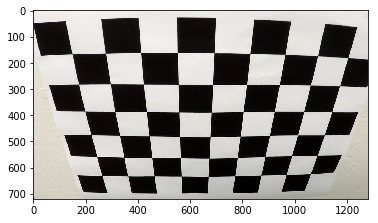

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('camera_cal/calibration2.jpg')

plt.imshow(img)

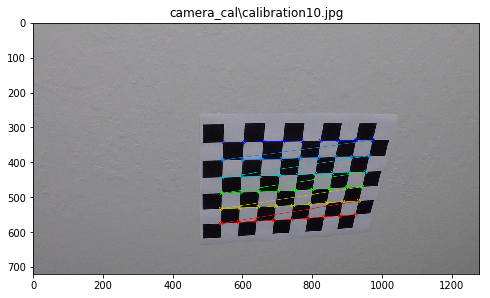

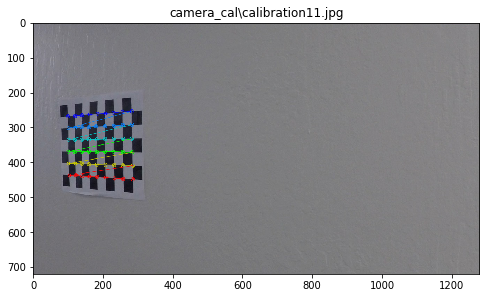

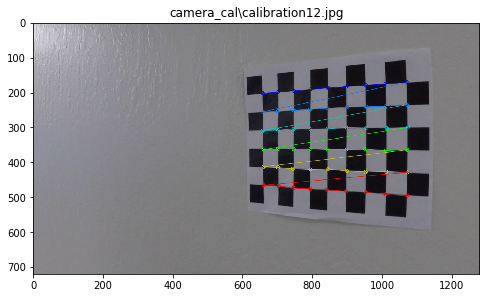

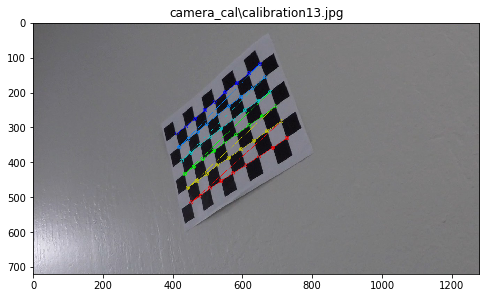

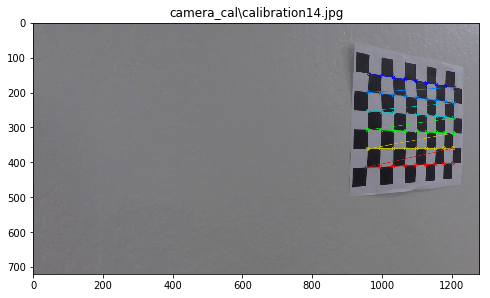

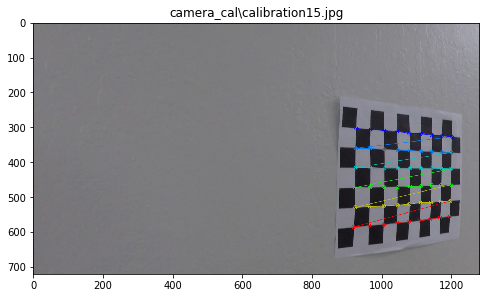

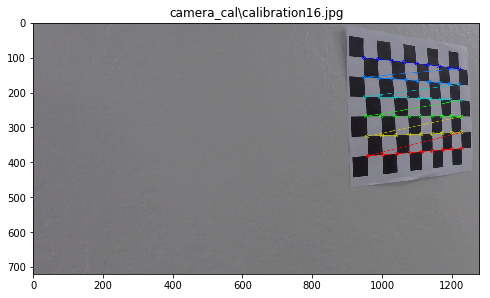

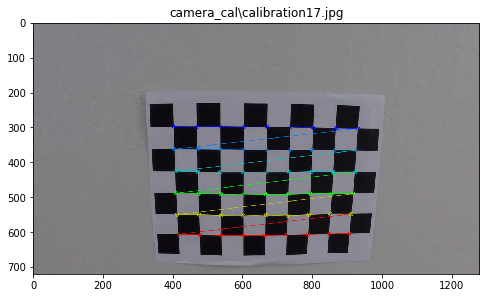

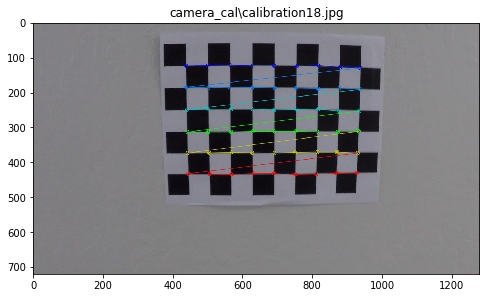

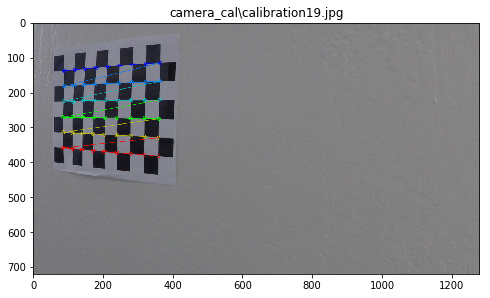

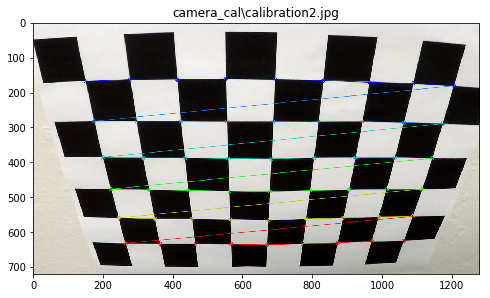

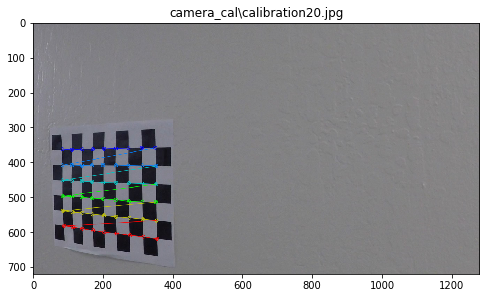

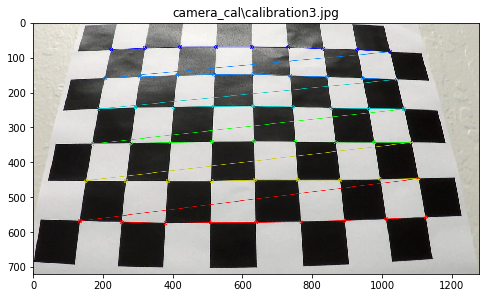

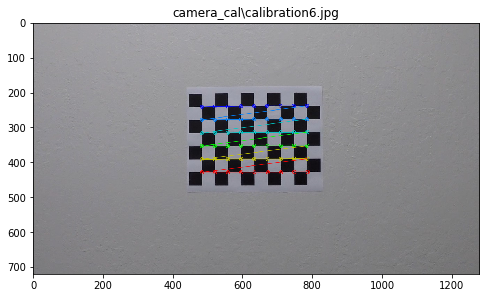

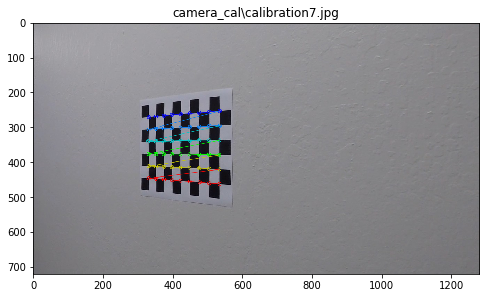

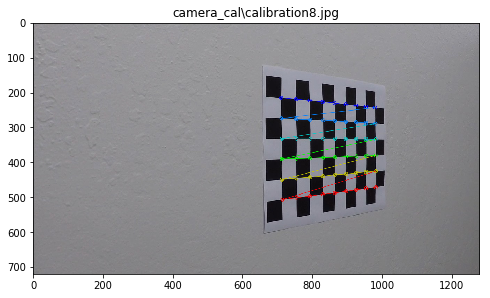

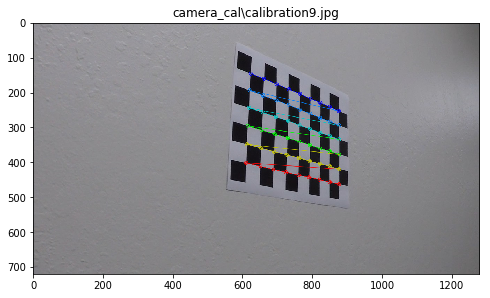

In [16]:
import glob

# chessboard corners counts
nx = 9
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints= [] # 2D points in image plane

# Prepare objects points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    
    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # if corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # display corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.figure(figsize=(8,14))
        plt.title(fname)
        plt.imshow(img)

In [17]:
# calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# fetching sample image for distortion
img_sample = mpimg.imread('camera_cal/calibration5.jpg')

# distorting
img_undist = cv2.undistort(img_sample, mtx, dist, None, mtx)

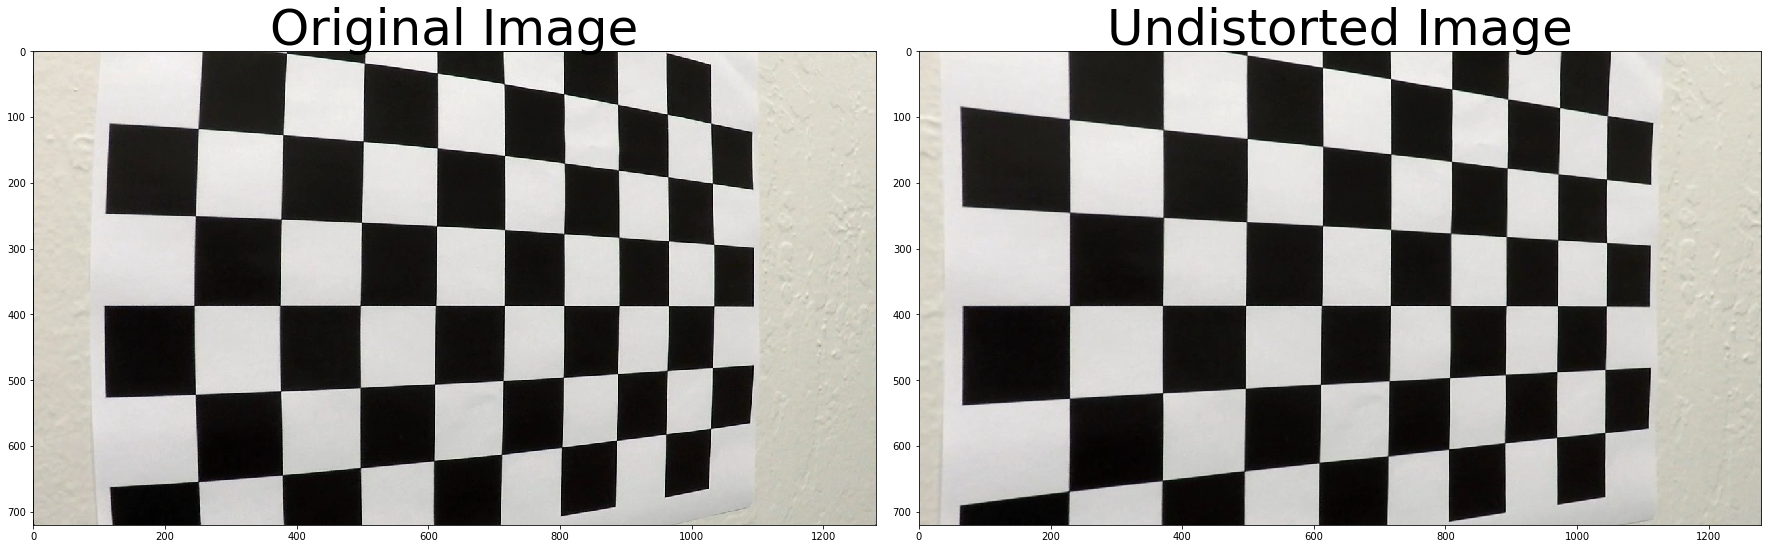

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
# show an image
def showImg(img, title=None, figsize=(8,14), map=None):
    plt.figure(figsize=figsize)
    if(title is not None):
        plt.title(fname)
    plt.imshow(img, cmap=map)

In [20]:
### image gradients thresholding functions

def getColorChannel(img, channel='gray'):
    ### returns grayscale of particular color channel of an image
    ### img - rgb image
    
    if(channel=='gray'):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif(channel=='h'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,0]
    elif(channel=='l'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,1]
    elif(channel=='s'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,2]
    elif(channel=='v'):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        return hsv[:,:,2]
    elif(channel=='r'):
        return img[:,:,0]
    elif(channel=='g'):
        return img[:,:,1]
    elif(channel=='b'):
        return img[:,:,2]
    
    return None

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), channel='gray'):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), channel='gray'):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_magnitude)
    sxbinary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), channel='gray'):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def color_threshold(img, thresh = (0, 255), channel='gray'):
    
    ### apply color threshold on color channel
    
    # getting grayscale of particular color channel
    gray = getColorChannel(img, channel)
    
    # 2) Apply a threshold to the image
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output


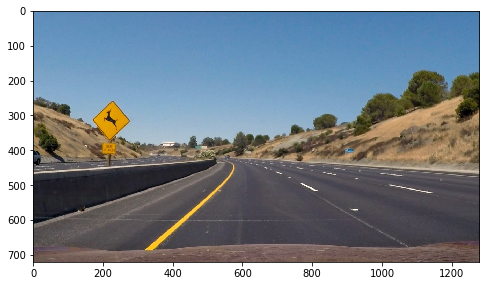

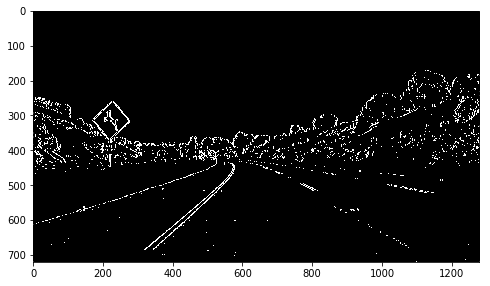

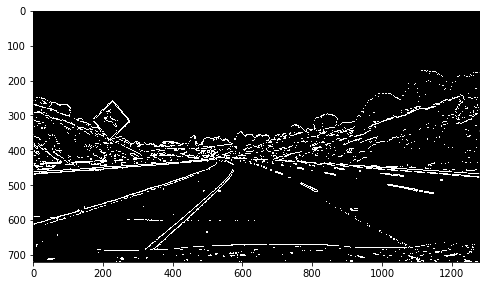

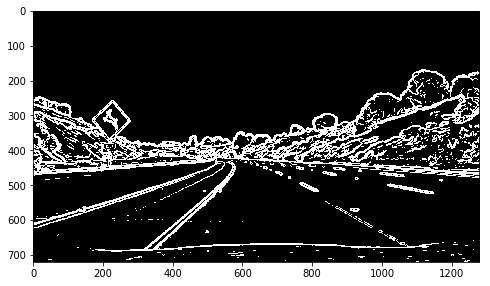

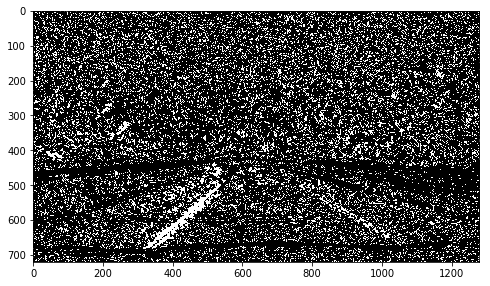

In [21]:
sampleImgFile = 'test_images/test2.jpg'

img = mpimg.imread(sampleImgFile)
showImg(img)

img1 = abs_sobel_thresh(img, orient='x', thresh=(30, 255))
showImg(img1, map='gray')

img1 = abs_sobel_thresh(img, orient='y', thresh=(30, 255))
showImg(img1, map='gray')

img2 = mag_thresh(img, sobel_kernel=13, mag_thresh=(30, 255))
showImg(img2, map='gray')

img3 = dir_threshold(img, sobel_kernel=25, thresh=(0.8, 1.1))
showImg(img3, map='gray')

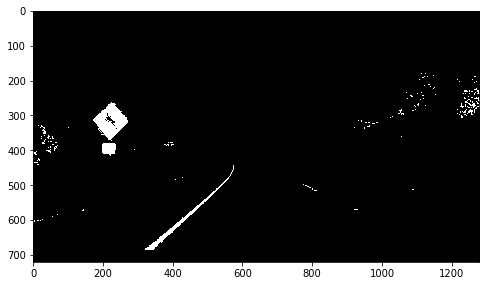

In [22]:
img4 = color_threshold(img, thresh=(170, 255), channel = 's')
showImg(img4, map='gray')

In [23]:
# setting points for perspective transform

leftBtX = 205 
leftBtY = 720
leftTpX = 590 
leftTpY = 450
rightTpX = 691 
rightTpY = 450
rightBtX = 1123 
rightBtY = 720

leftBtXTr = 320
leftBtYTr = 720
leftTpXTr = 320 
leftTpYTr = 0
rightTpXTr = 960 
rightTpYTr = 0
rightBtXTr = 960 
rightBtYTr = 720

src = np.float32(
        [[leftBtX,leftBtY],
         [leftTpX,leftTpY],
         [rightTpX,rightTpY],
         [rightBtX,rightBtY]])
    
dst = np.float32(
        [[leftBtXTr,leftBtYTr],
         [leftTpXTr,leftTpYTr],
         [rightTpXTr,rightTpYTr],
         [rightBtXTr,rightBtYTr]])

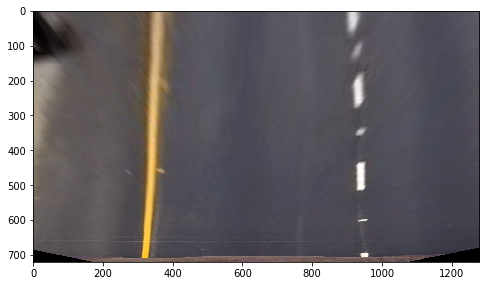

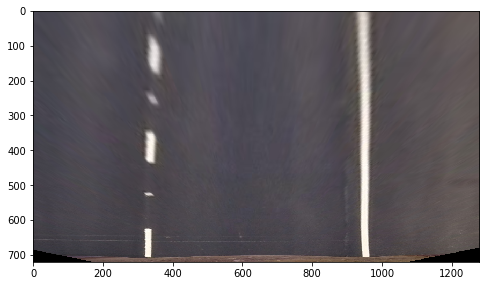

In [24]:
def drawPerspectiveLines(img, color=[255, 0, 0], thickness=3):
    ### draw lines between points for perspective transform
    cv2.line(img, (leftBtX, leftBtY),(leftTpX, leftTpY), color, thickness)
    cv2.line(img, (leftTpX, leftTpY),(rightTpX, rightTpY), color, thickness)
    cv2.line(img, (rightTpX, rightTpY),(rightBtX, rightBtY), color, thickness)
    cv2.line(img, (rightBtX, rightBtY),(leftBtX, leftBtY), color, thickness)
    
def transPerspective(img):
    ### apply perspective transform
    # get image size
    img_size = (img.shape[1],img.shape[0])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

straitLineImg1 = mpimg.imread('test_images/straight_lines1.jpg')
straitLineImg2 = mpimg.imread('test_images/straight_lines2.jpg')

#drawPerspectiveLines(straitLineImg1)
#drawPerspectiveLines(straitLineImg2)

straitLineImg1 = transPerspective(straitLineImg1)
straitLineImg2 = transPerspective(straitLineImg2)

showImg(straitLineImg1)
showImg(straitLineImg2)

In [131]:
#import datetime as dt

def pipeline(initial_image, fileName=None):
    ### pipeline that exposes lane on image    
    #img = abs_sobel_thresh(initial_image, orient='x', thresh=(20, 100))
    #img = sThresh(initial_image, thresh=(170, 255))
    
    #gradx = abs_sobel_thresh(initial_image, orient='x', sobel_kernel=3, thresh=(30, 255))
    #grady = abs_sobel_thresh(initial_image, orient='y', sobel_kernel=3, thresh=(30, 255))
    #mag_binary = mag_thresh(initial_image, sobel_kernel=13, mag_thresh=(30, 255))
    #dir_binary = dir_threshold(initial_image, sobel_kernel=25, thresh=(0.8, 1.1))    
    
    #combined = np.zeros_like(dir_binary)
    #combined[(((gradx == 1) & (grady == 1)) & ((mag_binary == 1) & (dir_binary == 1))) | (color == 1)] = 1
    #combined[( (mag_binary == 1))] = 1
    
    gradx = abs_sobel_thresh(initial_image, orient='x', sobel_kernel=3, thresh=(20, 100), channel='gray')    
    mag_binary = mag_thresh(initial_image, sobel_kernel=3, mag_thresh=(30, 255), channel='l')
    color = color_threshold(initial_image, thresh = (140, 255), channel='gray')
    color1 = color_threshold(initial_image, thresh = (140, 255), channel='s')
    dir_thresh = dir_threshold(initial_image, sobel_kernel=3, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) | ((color == 1) & (color1 == 1))) )] = 1
    #combined = np.dstack(( np.zeros_like(gradx), gradx, color))
    
    #return transPerspective(combined);
    #mpimg.imsave('images/{}.jpg'.format(str(dt.datetime.now().time()).replace(':','')), initial_image)
    return combined

def process_image(image):
    ### image process function for video
    
    result = pipeline(image)
    
    # converting to 3 channel image for video
    if(len(result.shape) == 2):
        result = result[:,:,None]
        result = np.uint8(result*[1,1,1])
        result = np.uint8(255*result/np.max(result))        
    
    return result;

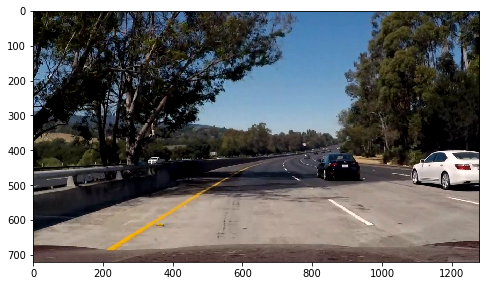

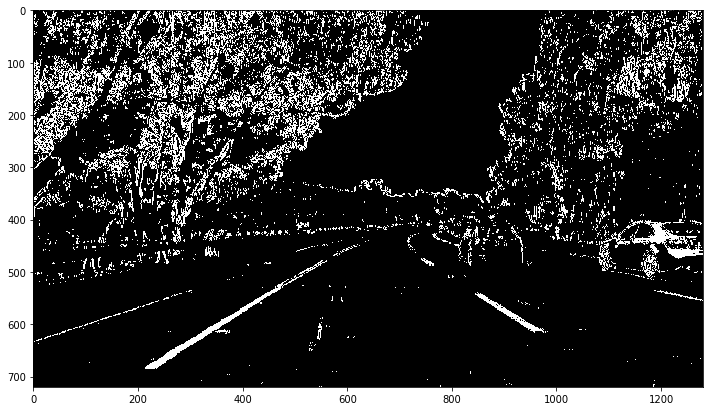

In [132]:
sampleImgFile = 'images/084907.836401.jpg'

img = mpimg.imread(sampleImgFile)
showImg(img, figsize=(8,14))

img1 = process_image(img)
showImg(img1, figsize=(12,21))

In [133]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processVideo(videoFile, videoFileOut=None):
    ### video of processed image
    
    videoIn = videoFile    
    
    if(videoFileOut is None):
        name, ext = os.path.splitext(videoIn)
        videoOut = name + '_out' + ext
    else:
        videoOut = videoFileOut
    
    clip = VideoFileClip(videoIn)
    clipProcessed = clip.fl_image(process_image)
    clipProcessed.write_videofile(videoOut, audio=False)
    return videoOut

In [134]:
videoFileName = 'project_video.mp4'
ouputVideo = processVideo('project_video.mp4')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:30<00:00,  3.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [135]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(ouputVideo))